## 1. Setup

In [1]:
import sys
sys.path.append('..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from unet import unet
from utils.dataset_utils import load_dataset_split, load_results, load_results_with_sal_maps
from utils.dataset_utils import load_images_from_list
from utils.evaluation import jaccard_and_dice
from utils.input_output import read_json
from utils.preprocessing import merge_patches_directly_and_save_all
from utils.vis_utils import plot_image_mask_prediction, grid_vis

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### 1.1 Parameters of the experiment (and hyperparameters from ../config.py)

In [4]:
UNET_NAME = config.UNET_NAME
EXPERIMENT_NAME = config.EXPERIMENT_NAME
DATASET_PATH = f'../datasets/{config.DATASET_NAME}'
UNSEEN_CATEGORIES_PATH = f'../datasets/unseen_categories'

In [5]:
CHECKPOINTS_PATH = f'../checkpoints'
CHECKPOINT_FILENAME = f'{CHECKPOINTS_PATH}/{EXPERIMENT_NAME}/{UNET_NAME}.hdf5'
LOGS_PATH = f'../logs'
LOGS_FILENAME = f'{LOGS_PATH}/{EXPERIMENT_NAME}.json'
RESULTS_PATH = f'../results/{EXPERIMENT_NAME}'

## 2. Load train/val/test splits and unseen_categories images

In [6]:
train_images, train_masks, train_preds = load_results(dataset_path=DATASET_PATH,
                                                      results_path=RESULTS_PATH,
                                                      split_name='train')

val_images, val_masks, val_preds = load_results(dataset_path=DATASET_PATH,
                                                results_path=RESULTS_PATH,
                                                split_name='val')

test_images, test_masks, test_preds = load_results(dataset_path=DATASET_PATH,
                                                   results_path=RESULTS_PATH,
                                                   split_name='test')

unseen_cat_images_dir = f'{UNSEEN_CATEGORIES_PATH}/test/test_img_from_patches'
unseen_cat_images = load_images_from_list(sorted(os.listdir(unseen_cat_images_dir)),
                                          unseen_cat_images_dir) / 255.

unseen_cat_sal_maps_dir = f'{UNSEEN_CATEGORIES_PATH}/test/test_{config.BACKPROP_MODIFIER}_sal_from_patches'
unseen_cat_sal_maps = load_images_from_list(sorted(os.listdir(unseen_cat_sal_maps_dir)),
                                            unseen_cat_sal_maps_dir) / 255.

unseen_cat_preds_dir = f'{RESULTS_PATH}/unseen_cat_test/test_pred_from_patches'
unseen_cat_preds = load_images_from_list(sorted(os.listdir(unseen_cat_preds_dir)),
                                          unseen_cat_preds_dir) / 255.

## 3. First plots (sanity check)

dataset_split: test


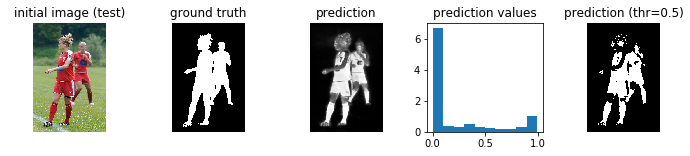

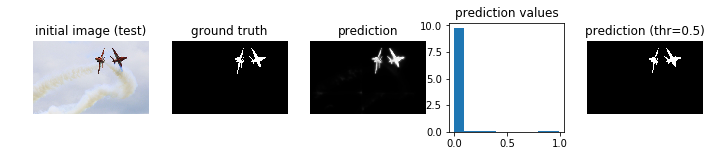

In [7]:
plot_image_mask_prediction(test_images[[5, 7]], test_masks[[5, 7]], test_preds[[5, 7]],
                           dataset_split='test', pred_thr=config.PRED_THR)

## 4. IoU and Dice

In [8]:
def jaccard_and_dice_var_thrs(preds, masks, thrs=set([.4, .5, .6])):
    return {thr: jaccard_and_dice(preds=preds, gts=masks, thr=thr)
            for thr in thrs}

def plot_jaccard_and_dice_var_thrs(datasplit_eval, split_name):
    plt.figure(figsize=(8, 5))
    plt.title(f'IoU and Dice coefficients ({split_name} split)')
    plt.ylabel('similarity coefficient')
    plt.xlabel('images (sorted by their coefficients)')
    for idx, thr in enumerate(sorted(datasplit_eval.keys())):
        jaccard_coef = datasplit_eval[thr][:, 0]
        dice_coef = datasplit_eval[thr][:, 1]
        p = plt.plot(sorted(jaccard_coef), label=f'IoU (thr={thr})')
        plt.plot(sorted(dice_coef), '--', label=f'dice (thr={thr})',
                 color=p[0].get_color())
        plt.legend()

In [9]:
val_eval = jaccard_and_dice_var_thrs(preds=val_preds, masks=val_masks)
train_eval = jaccard_and_dice_var_thrs(preds=train_preds, masks=train_masks)
test_eval = jaccard_and_dice_var_thrs(preds=test_preds, masks=test_masks)

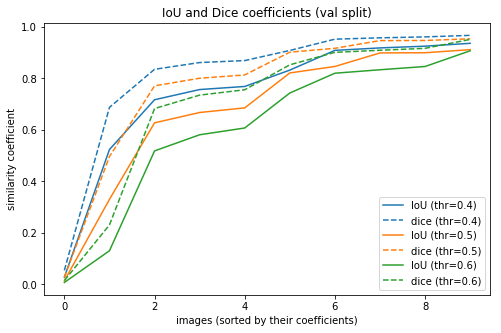

In [10]:
plot_jaccard_and_dice_var_thrs(val_eval, 'val')

In [11]:
def mean_std(data):
    return f'{data.mean():.3} \u00B1 {data.std():.3}'

# data
print(f'pred_thr: {config.PRED_THR}')
data = np.array([mean_std(train_eval[config.PRED_THR][:, 0]),
                 mean_std(train_eval[config.PRED_THR][:, 1]),
                 mean_std(val_eval[config.PRED_THR][:, 0]),
                 mean_std(val_eval[config.PRED_THR][:, 1]),
                 mean_std(test_eval[config.PRED_THR][:, 0]),
                 mean_std(test_eval[config.PRED_THR][:, 1])]).reshape(1, -1)

# header
header = pd.MultiIndex.from_product([['Train','Val', 'Test'],
                                     ['IoU','Dice']],
                                    names=['', ''])
# index
index = pd.MultiIndex.from_product([[UNET_NAME],
                                     [config.DATASET_NAME]],
                                    names=['Experiment name', 'Dataset name'])
# df
df = pd.DataFrame(data=data, index=index, columns=header)

# style
d = dict(selector="th", props=[('text-align', 'center')])
df.style.set_properties(**{'width':'10em', 'text-align':'center'})\
        .set_table_styles([d])

# save
df.to_csv(f'{RESULTS_PATH}/{UNET_NAME}_eval.csv', index=True)

# print
df.head(1)

pred_thr: 0.5


Train                 \
                                                   IoU           Dice   
Experiment name         Dataset name                                    
UNet_RGB_SAL_MAP_GUIDED icoseg/subset_80  0.72 ± 0.223  0.813 ± 0.189   

                                                   Val                 \
                                                   IoU           Dice   
Experiment name         Dataset name                                    
UNet_RGB_SAL_MAP_GUIDED icoseg/subset_80  0.67 ± 0.277  0.757 ± 0.276   

                                                  Test                
                                                   IoU          Dice  
Experiment name         Dataset name                                  
UNet_RGB_SAL_MAP_GUIDED icoseg/subset_80  0.682 ± 0.26  0.773 ± 0.25

## 5. Look at some results

In [12]:
good_preds_ind = [6, 7, 10]
bad_preds_ind =  [9, 18, 19]

In [13]:
apply_thr = lambda images, thr: [img >= thr for img in images]

def get_test_images(img_range):
    test = load_results_with_sal_maps(dataset_path=DATASET_PATH,
                                      results_path=RESULTS_PATH,
                                      split_name='test',
                                      img_range=img_range,
                                      backprop_modifier=config.BACKPROP_MODIFIER)

    test_images, test_sal_maps, test_masks, test_preds = test

    test_preds_40 = apply_thr(test_preds, 0.4)
    test_preds_50 = apply_thr(test_preds, 0.5)
    test_preds_60 = apply_thr(test_preds, 0.6)

    test = np.array([test_images,
                     test_sal_maps,
                     test_masks,
                     test_preds,
                     test_preds_40,
                     test_preds_50,
                     test_preds_60]).transpose().flatten()
    
    return test

--------------------------------------------- Good results ---------------------------------------------

   Initial image   Saliency Map (guided)  GT          Prediction    Pred(thr=0.4)    Pred(thr=0.5)   Pred(thr=0.6)


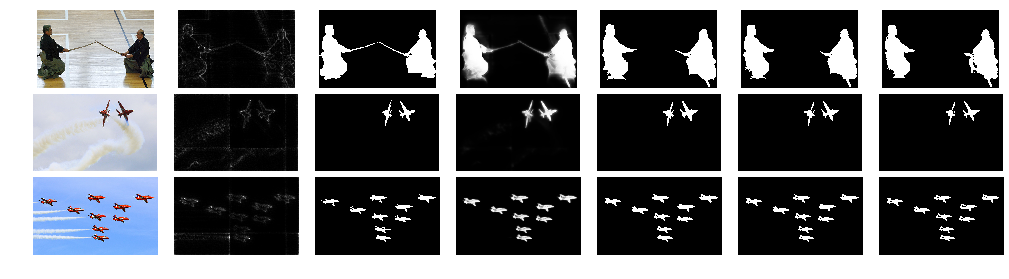

In [14]:
print('--------------------------------------------- Good results ---------------------------------------------\n')
print(f'   Initial image   Saliency Map ({config.BACKPROP_MODIFIER})  GT          '\
      f'Prediction    Pred(thr=0.4)    Pred(thr=0.5)   Pred(thr=0.6)')
test_good = get_test_images(good_preds_ind)
grid_vis(test_good, grid_rows=len(good_preds_ind), grid_cols=7,
         grid_col_dim=2.5, grid_row_dim=1.5)

---------------------------------------------- Bad results ---------------------------------------------

   Initial image   Saliency Map (guided)  GT          Prediction     Pred(thr=0.4)  Pred(thr=0.5)   Pred(thr=0.6)


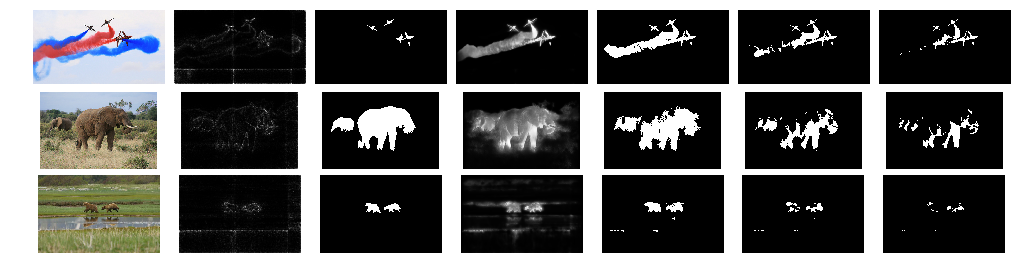

In [15]:
print('---------------------------------------------- Bad results ---------------------------------------------\n')
print(f'   Initial image   Saliency Map ({config.BACKPROP_MODIFIER})  GT          '\
      f'Prediction     Pred(thr=0.4)  Pred(thr=0.5)   Pred(thr=0.6)')
test_bad = get_test_images(bad_preds_ind)
grid_vis(test_bad, grid_rows=len(bad_preds_ind), grid_cols=7,
         grid_col_dim=2.5, grid_row_dim=1.5)

----------------------------------------- Unseen categories results -----------------------------------------------

    Initial image  Saliency maps (guided)   Prediction       Pred(thr=0.4)       Pred(thr=0.5)     Pred(thr=0.6)


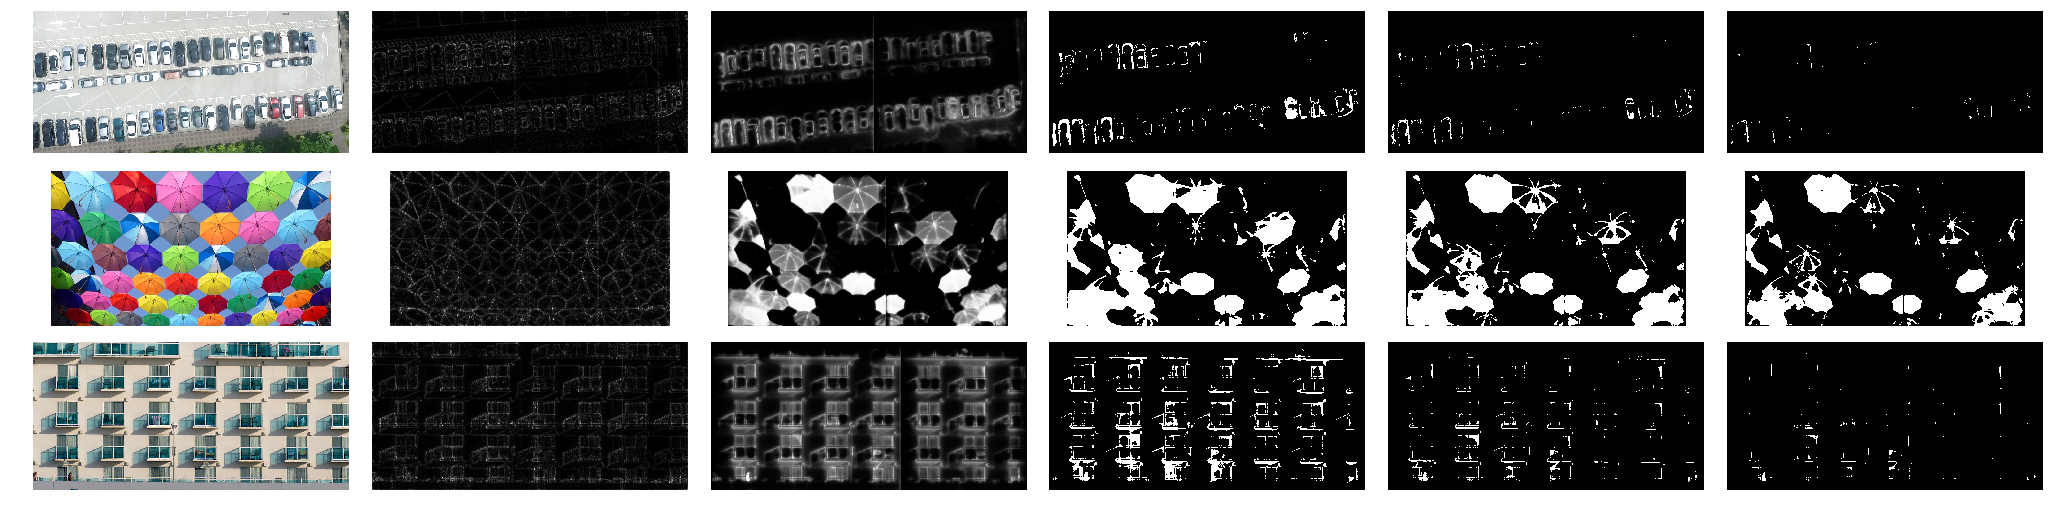

In [16]:
print(f'----------------------------------------- Unseen categories results ----'
      f'-------------------------------------------\n')
print(f'    Initial image  Saliency maps ({config.BACKPROP_MODIFIER})   Prediction       Pred(thr=0.4)       '
      f'Pred(thr=0.5)     Pred(thr=0.6)')

unseen_cat_preds_40 = apply_thr(unseen_cat_preds, 0.4)
unseen_cat_preds_50 = apply_thr(unseen_cat_preds, 0.5)
unseen_cat_preds_60 = apply_thr(unseen_cat_preds, 0.6)

unseen_cat = np.array([unseen_cat_images,
                       unseen_cat_sal_maps,
                       unseen_cat_preds,
                       unseen_cat_preds_40,
                       unseen_cat_preds_50,
                       unseen_cat_preds_60]).transpose().flatten()

grid_vis(unseen_cat, grid_rows=len(unseen_cat_images), grid_cols=6,
         grid_col_dim=6, grid_row_dim=3)